In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import h5py
import os
import dill as pickle
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import torch 
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
from torch.utils.data import Subset
import random
import torch.optim as optim
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Device: cuda


## Get metric #1 and test how it works

I need to understand input type, output type etc.

In [2]:
# Original score function changed to work without dataframe
"""
2024 ISIC Challenge primary prize scoring metric

Given a list of binary labels, an associated list of prediction 
scores ranging from [0,1], this function produces, as a single value, 
the partial area under the receiver operating characteristic (pAUC) 
above a given true positive rate (TPR).
https://en.wikipedia.org/wiki/Partial_Area_Under_the_ROC_Curve.

(c) 2024 Nicholas R Kurtansky, MSKCC
"""

import numpy as np
import pandas as pd
import pandas.api.types
from sklearn.metrics import roc_curve, auc, roc_auc_score

class ParticipantVisibleError(Exception):
    pass


def score(y_true, y_pred, min_tpr: float=0.80) -> float:
    '''
    2024 ISIC Challenge metric: pAUC
    
    Given a solution file and submission file, this function returns the
    the partial area under the receiver operating characteristic (pAUC) 
    above a given true positive rate (TPR) = 0.80.
    https://en.wikipedia.org/wiki/Partial_Area_Under_the_ROC_Curve.
    
    (c) 2024 Nicholas R Kurtansky, MSKCC

    Args:
        solution: ground truth pd.DataFrame of 1s and 0s
        submission: solution dataframe of predictions of scores ranging [0, 1]

    Returns:
        Float value range [0, max_fpr]
    '''

    # rescale the target. set 0s to 1s and 1s to 0s (since sklearn only has max_fpr)
    v_gt = abs(np.asarray(y_true)-1)
    
    # flip the submissions to their compliments
    v_pred = -1.0*np.asarray(y_pred)
    
    max_fpr = abs(1-min_tpr)

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        
    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

#     # Equivalent code that uses sklearn's roc_auc_score
#     v_gt = abs(np.asarray(solution.values)-1)
#     v_pred = np.array([1.0 - x for x in submission.values])
#     max_fpr = abs(1-min_tpr)
#     partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
#     # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
#     # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
#     partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return(partial_auc)

y_true = pd.DataFrame({'feature1': list(range(50)),
        'target': [random.randint(0, 1) for _ in range(50)]})
y_pred = pd.DataFrame({'feature1': list(range(50)),
                       'target': [random.randint(0, 1) for _ in range(50)]})

y_true = [random.randint(0, 1) for _ in range(50)]
y_pred = [random.uniform(0, 1) for _ in range(50)]

score(y_true, y_pred)

0.04967948717948717

# Create Dataset

In [3]:
# Simple exploration of data
train = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv')
test = pd.read_csv('/kaggle/input/isic-2024-challenge/test-metadata.csv')
train['target'].value_counts()

/tmp/ipykernel_24/1094116626.py:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv')


target
0    400666
1       393
Name: count, dtype: int64

In [4]:
from io import BytesIO
import h5py
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class hdf5_dataset(Dataset):
    """
    This class creates pytorch dataset from .hdf5 file
    Args & Kwargs:
        h5_fle: url of the h5 file with the data
        dataframe: pandas dataframe with targets column
        target_column: name of the column with targets if empy doesnt return target
        transform: if transform of the data is needed
    Example:
        dataset = hdf5_dataset(h5_file=h5_file_url, csv_file=csv_file_url, transform=transform)
    """
    
    def __init__(self, h5_file:str, 
                 dataframe:pd.DataFrame,
                 target_column:str=None,
                 transform=None):
        self.h5_file = h5_file
        self.transform = transform
        
        # Open h5 file
        self.file = h5py.File(h5_file, 'r') 
        self.keys = list(self.file.keys())
        
        # Read dataframe
        self.df = dataframe
        self.target_column = target_column
        
        if self.target_column:
            self.targets = dataframe[self.target_column].values
        
    def __len__(self):
        return len(self.df) # return lenth of the dataframe
    
    def __getitem__(self, index):
        
        # Get label from dataframe
        
        key = self.keys[index]
        # get data from file
        img_data = self.file[self.keys[index]][()]
        # Decode image 
        img = Image.open(BytesIO(img_data))
        # Transform image
        if self.transform:
            img = self.transform(img)
        else:
            # Convert to tensor if no transform is provided
            img = transforms.ToTensor()(img)
            
        if self.target_column:
            target = self.targets[index]
            return img, target#, key            
        else:
            return img#, key
    
    def __del__(self):
        # Close file when dataset deleted
        if self.file:
            self.file.close()

In [5]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 512

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset = hdf5_dataset(h5_file='/kaggle/input/isic-2024-challenge/train-image.hdf5', 
                       dataframe=train,
                       target_column='target',
                       transform=transform)

test_dataset = hdf5_dataset('/kaggle/input/isic-2024-challenge/test-image.hdf5', 
                       dataframe=test,
                       transform=transform)

len(dataset), len(test_dataset)

(401059, 3)

## Split Dataset into train_dataset and val_dataset
Dataset can be unballanced so I'll use stratified ShuffleSplit

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
from collections import Counter

def split_pytorch_dataset(dataset:torch.utils.data.Dataset,
                          test_size:float=0.2,
                          seed=42):
    """
    Splits highly unballanced dataset into two parts.
    Args:
        dataset: pytorch dataset
        test_size: float value to define size of test set
    Returns:
        two pytorch subsets and it's weigts
    Example:
        train_dataset, test_dataset, train_weights, val_weights = split_pytorch_dataset(dataset=dataset, test_size=0.2)
    """
    # Get targets
    targets = dataset.targets
    
    # Split only once
    sss = StratifiedShuffleSplit(n_splits=1,
                                 test_size=test_size,
                                 random_state=seed)
    
    for train_idx, test_idx in sss.split(list(range(len(targets))), targets):
        train_dataset = Subset(dataset, train_idx)
        test_dataset = Subset(dataset, test_idx)
        
    # Count number of classes in each subset
    train_targets = [dataset.targets[i] for i in train_idx]
    test_targets = [dataset.targets[i] for i in test_idx]
    
    train_classes = Counter(train_targets)
    test_classes = Counter(test_targets)
    
    # Count weights for each class
    train_weights = {cls: len(train_idx) / count for cls, count in train_classes.items()}
    test_weights = {cls: len(test_idx) / count for cls, count in test_classes.items()}
   
    # Check pos_weight for binary and weights for multiclass
    if len(train_weights) <= 2:
        print("Return pos_weight for class 1")
        train_weights = torch.tensor(train_weights[1], dtype=torch.float32)
        test_weights = torch.tensor(test_weights[1], dtype=torch.float32)
        print(f"Weight for pos_weight: train {train_weights}, test {test_weights}")
    else:
        print("Retun normalized weights for each class")
        train_total_weight = sum(train_weights.values())
        test_total_weight = sum(test_weights.values())
        
        # Normalize weights
        train_weights = {cls: weight / train_total_weight for cls, weight in train_weights.items()}
        test_weights = {cls: weight / test_total_weight for cls, weight in test_weights.items()}
        
        
        # Conver weights into tensors
        train_weights = torch.tensor([train_weights[cls] for cls in sorted(train_weights.keys())], dtype=torch.float32)
        test_weights = torch.tensor([test_weights[cls] for cls in sorted(test_weights.keys())], dtype=torch.float32)
        print(f"Weight for pos_weight: train {train_weights}, test {test_weights}")
        
    print(f"Dataset splitted into")
    print(f"Train dataset contains of: {train_classes}")
    print(f"Test dataset contains of: {test_classes}")
    print(f"Lenth of datasets: {len(train_dataset)}, {len(test_dataset)}")
        
    return train_dataset, test_dataset, train_weights, test_weights

train_dataset, val_dataset, train_weights, val_weights = split_pytorch_dataset(dataset=dataset, test_size=0.2, seed=SEED)

Return pos_weight for class 1
Weight for pos_weight: train 1021.8057250976562, test 1015.341796875
Dataset splitted into
Train dataset contains of: Counter({0: 320533, 1: 314})
Test dataset contains of: Counter({0: 80133, 1: 79})
Lenth of datasets: 320847, 80212


In [7]:
num_cores = os.cpu_count()
# Create dataloaders
train_dataloader = DataLoader(train_dataset, 
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=num_cores)
val_dataloader = DataLoader(val_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                            num_workers=num_cores)
test_dataloader = DataLoader(test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False)

In [8]:
# train_weights2 = train_weights[1:].to(device)
# train_weights2

## Create CV model

In [9]:
class ResNetCNN(nn.Module):
    def __init__(self):
        super(ResNetCNN, self).__init__()
        
        # Load weights
        weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2 # Load weights
        self.model = torchvision.models.resnet50(weights=weights) # Load model
        
        for name, param in self.model.named_parameters():
            param.requires_grad = False
            
        self.model.fc = nn.Sequential(nn.Linear(self.model.fc.in_features, 224),
                                     nn.ReLU(),
                                     nn.Dropout(),
                                     nn.Linear(224, 1), # This is for binary classification
                                     nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)

In [10]:
model = ResNetCNN()
model = torch.nn.DataParallel(model)

loss_fn = nn.BCEWithLogitsLoss(pos_weight=train_weights.to(device))
optimizer = optim.Adam(params=model.parameters(),
                      lr=0.0001)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:05<00:00, 17.7MB/s]


In [11]:
from tqdm.auto import tqdm

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):

    """
    Trains PyTorch model for one epoch.
    Args:
        model: PyTorch model
        dataloader: A DataLoader instance
        metric_function: for example accuracy, f1, etc. or custom 
        gets y_true and y_pred arrays 
        loss_fn: Loss function
        optimizer: Optimizer

    Returns:
        A tuple of training loss and predictions
    """
    train_loss = 0
    
    y_preds, y_trues = [], []
    
    # Turn on train mode
    model.train()
    for batch, (X, y) in tqdm(enumerate(dataloader)):
        
        # Send data to device
        X, y = X.to(device), y.to(torch.float32).to(device)

        # Forward pass
        y_preds_batch = model(X)
        
        # Calculate the losss
        loss = loss_fn(torch.squeeze(y_preds_batch, dim=1), y)
        
        train_loss += loss.item()
        # Optimizer zero grad
        optimizer.zero_grad()
        # Loss backward
        loss.backward()
        # Optimizer step
        optimizer.step()
        
        # Collect preds and trues
        y_trues.extend(y.detach().cpu().numpy())
        y_preds.extend(torch.squeeze(y_preds_batch, dim=1).detach().cpu().numpy())

    train_loss = train_loss / len(dataloader)

    return train_loss, np.array(y_preds), np.array(y_trues)


def val_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device: torch.device):

    """
    Performs PyTorch model's validation during one epoch.
    Args:
    model: PyTorch model
    dataloader: A DataLoader instance
    loss_fn: Loss function
    device: Device "cpu" or "cuda"

    Returns:
    A tuple of val loss and accuracy
    """
    val_loss = 0
    y_trues, y_preds = [], []
    
    # Turn on eval mode
    model.eval()
    
    with torch.inference_mode():

        for batch, (X, y) in enumerate(dataloader):

            # Send data to device
            X, y = X.to(device), y.to(torch.float32).to(device)

            # Forward pass
            y_preds_batch = model(X) 
             
            # Calculate the losss
            loss = loss_fn(torch.squeeze(y_preds_batch, dim=1), y)

            val_loss += loss.item()
            
            y_trues.extend(y.detach().cpu().numpy())
            y_preds.extend(torch.squeeze(y_preds_batch, dim=1).detach().cpu().numpy())
        
    val_loss = val_loss / len(dataloader)

    return val_loss, np.array(y_preds), np.array(y_trues)


def get_predictions(model: torch.nn.Module,
                    dataloader: torch.utils.data.DataLoader,
                    device: torch.device):

    """
    Performs PyTorch model's predictions
    Args:
        model: PyTorch model
        dataloader: A DataLoader instance 

    Returns:
        predictons in np.array
    """
    y_preds = []
    
    # Turn on eval mode
    model.eval()
    
    with torch.inference_mode():

        for batch, (X) in enumerate(dataloader):

            # Send data to device
            X = X.to(device)

            # Make predictions
            y_preds_batch = model(X) 
            
            # Put preds into list in np format
            y_preds.extend(torch.squeeze(y_preds_batch, dim=1).detach().cpu().numpy())

    return np.array(y_preds)


def train_model(model: torch.nn.Module,
                metric_function,
                train_dataloader: torch.utils.data.DataLoader,
                val_dataloader: torch.utils.data.DataLoader,
                optimizer: torch.optim.Optimizer,
                loss_fn: torch.nn.Module,
                epochs: int,
                device: torch.device):

    """
    Trains PyTorch model for N epochs
    Args: 
        model: Pytorch model
        metric_function: Some function that gets y_true and y_pred as input and returns score
        train_dataloader: Pytorch dataloader
        val_dataloader: Pytorch validation dataloader
        optimizer: Pytorch optimizer
        loss_fn: Loss function
        epochs: number of epochs to train
        device: CPU or CUDA
        
    Returns:
        Dictionaries of Train Loss, Val Loss, Train Acc, Val Accuracy.
        If test dataloader in input it also returns final test Loss and Test accuracy
    """
    # Move model to device
    model.to(device)
    print(f"Device: {device}")

    train_metrics, val_metrics, train_loss, val_loss = [], [], [], []

    for epoch in tqdm(range(epochs)):
        # Run train and collect results in list
        train_loss_ep, train_preds_ep, train_true_labels = train_step(model=model,
                                                    dataloader=train_dataloader,
                                                    loss_fn=loss_fn,
                                                    optimizer=optimizer,
                                                    device=device)
        train_loss.append(train_loss_ep)

        # Run validation and collect preds in list
        val_loss_ep, val_preds_ep, val_true_labels = val_step(model=model,
                                              dataloader=val_dataloader,
                                              loss_fn=loss_fn,
                                              device=device)
        val_loss.append(val_loss_ep)
        
        # Count metric for epoch
        train_metric_ep = metric_function(y_true=train_true_labels,
                                          y_pred=train_preds_ep)
        val_metric_ep = metric_function(y_true=val_true_labels,
                                        y_pred=val_preds_ep)
        
        train_metrics.append(train_metric_ep)
        val_metrics.append(val_metric_ep)
        
        print(f"""Epoch {epoch+1}_ _ _ _ _ _ _ _ _ _
              Train loss: {train_loss_ep:.5f}
              Val   loss: {val_loss_ep:.5f}
              Train metric: {train_metric_ep:.5f}
              Val   metric: {val_metric_ep:.5f}""")
    
    return train_metrics, val_metrics, train_loss, val_loss

In [12]:
train_acc, val_acc, train_loss, val_loss =train_model(model=model,
                                                      metric_function=score,
                                                        train_dataloader=train_dataloader,
                                                        val_dataloader=val_dataloader,
                                                        optimizer=optimizer,
                                                        loss_fn=loss_fn,
                                                        epochs=1,
                                                        device=device)

# Save model
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

Device: cuda


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 1_ _ _ _ _ _ _ _ _ _
              Train loss: 1.38408
              Val   loss: 1.37276
              Train metric: 0.02087
              Val   metric: 0.03998


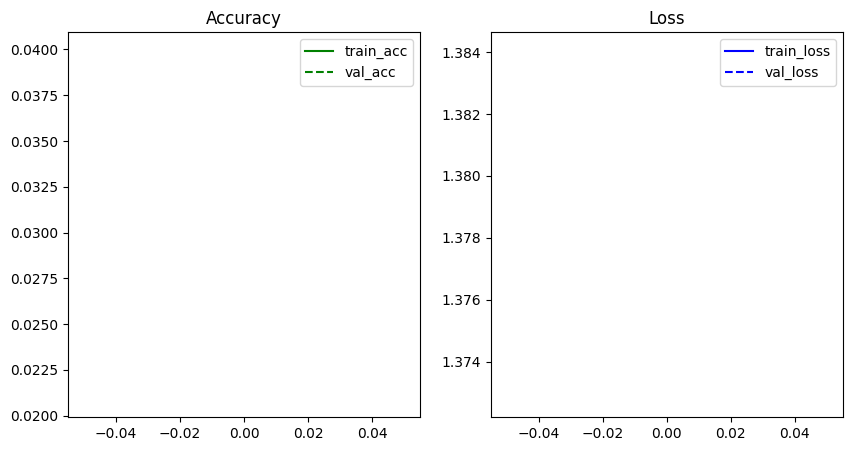

In [13]:
def plot_loss_curves(train_acc, val_acc, train_loss, val_loss):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, c="green", label="train_acc")
    plt.plot(val_acc, c="green", linestyle="dashed", label="val_acc")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)

    plt.plot(train_loss, c="blue", label="train_loss")
    plt.plot(val_loss, c="blue", linestyle="dashed", label="val_loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

plot_loss_curves(train_acc,
                 val_acc,
                 train_loss,
                 val_loss)

## Make predictions

In [14]:
preds = get_predictions(model=model,
                        dataloader=test_dataloader,
                        device=device)

test_df = pd.DataFrame({'isic_id': test['isic_id'].values,
                        'target': preds})

test_df.to_csv('submission.csv', index=False)

test_df

,isic_id,target
0,ISIC_0015657,0.232138
1,ISIC_0015729,0.033327
2,ISIC_0015740,0.143333
